In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [109]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

spark.read.csv("Customer.csv", header=True).createOrReplaceTempView("customer")
spark.read.csv("DetailTransaction.csv", header=True).createOrReplaceTempView("transactiondetail")
spark.read.csv("HeaderTransaction.csv", header=True).createOrReplaceTempView("transactionheader")
spark.read.csv("Jacket.csv", header=True).createOrReplaceTempView("jacket")
spark.read.csv("JacketType.csv", header=True).createOrReplaceTempView("jackettype")
spark.read.csv("Staff.csv", header=True).createOrReplaceTempView("staff")




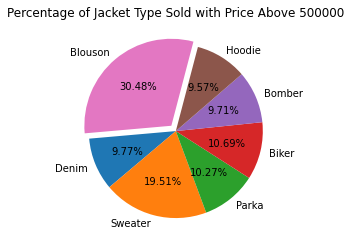

In [135]:
# a.	Show the percentage of jacket type sold in which the jacket price must be above 500000 using pie plot. 

answer1 = spark.sql("""
  select jt.jackettypename, sum(td.quantity) as sold
  from jacket j
  join transactiondetail td on td.jacketid = j.jacketid
  join jackettype jt on jt.jackettypeid = j.jackettypeid
  where j.price > 500000
  group by jt.jackettypename, jt.jackettypeid
""").toPandas()

plt.pie(
    answer1["sold"],
    labels = answer1["jackettypename"],
    autopct = "%.2f%%",
    startangle = 185,
    explode = (0,0,0,0,0,0,0.08)
)

plt.title("Percentage of Jacket Type Sold with Price Above 500000")
plt.show()



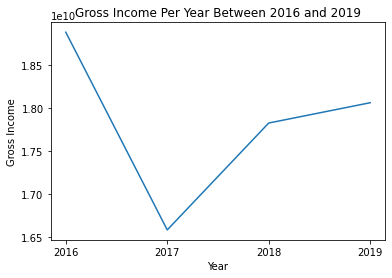

In [22]:
# b.	Show the number of gross income per year between 2016 until 2019 using line plot.

answer2 = spark.sql("""
  select year(th.transactiondate) as year, sum(j.price * td.quantity) as grossincome
  from jacket j
  join transactiondetail td on td.jacketid = j.jacketid
  join transactionheader th on th.transactionid = td.transactionid
  where year(th.transactiondate) between 2016 and 2019
  group by year
  order by year
""").toPandas()

plt.plot(
    answer2["year"],
    answer2["grossincome"]
)

plt.title("Gross Income Per Year Between 2016 and 2019")
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.xticks(range(2016, 2020))

plt.show()

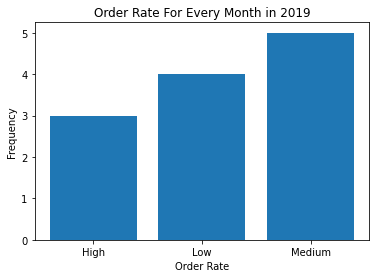

In [29]:
# c.	Show the frequency of the order rate for every month in 2019 using bar plot. 
# The order rate in a certain month is determined based on the following condition: 

# Order Rate	Jackets Ordered per Month
# High	> 4000
# Medium	2501 - 4000
# Low	<= 2500

answer3 = spark.sql("""
  select count(orderrate) as frequency, orderrate
  from(
  select 
  case
    when sum(quantity) > 4000 then 'High'
    when sum(quantity) between 2501 and 4000 then 'Medium'
    when sum(quantity) <= 2500 then 'Low'
  end as orderrate
  from jacket j
  join transactiondetail td on td.jacketid = j.jacketid
  join transactionheader th on th.transactionid = td.transactionid
  where year(transactiondate) = 2019
  group by month(transactiondate)
  )as sub1
  group by orderrate
""").toPandas()

plt.bar(
    answer3["orderrate"],
    answer3["frequency"]
)

plt.title("Order Rate For Every Month in 2019")
plt.xlabel("Order Rate")
plt.ylabel("Frequency")

plt.show()



In [96]:
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler

training = spark.read.csv("Train.csv", header = True, inferSchema=True)
testing = spark.read.csv("Test.csv", header = True, inferSchema= True)

columns = ["Glucose", "Insulin", "DiabetesPedigreeFunction"]

training = training.na.drop()
testing = testing.na.drop()

training = training.select(columns)
testing = testing.select("Glucose", "Insulin", "DiabetesPedigreeFunction", "Outcome")


# training = training.withColumn(
#     "LowerBackPain", 
#     when(training["LowerBackPain"] == "No", 0).
#     otherwise(1)
#   )

# training = training.withColumn(
#     "SugarInTake/day", 
#     when(training["SugarInTake/day"] == "Low", 0).
#     when(training["SugarInTake/day"] == "Medium", 1).
#     when(training["SugarInTake/day"] == "High", 2)
#   )

# testing = testing.withColumn(
#     "LowerBackPain", 
#     when(testing["LowerBackPain"] == "No", 0).
#     otherwise(1)
#   )

# testing = testing.withColumn(
#     "SugarInTake/day", 
#     when(testing["SugarInTake/day"] == "Low", 0).
#     when(testing["SugarInTake/day"] == "Medium", 1).
#     when(testing["SugarInTake/day"] == "High", 2)
#   )

testing = testing.withColumn(
    "Outcome",
    when(testing["Outcome"] == "No", 0).
    otherwise(1)
)
    
assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

training = assembler.transform(training)
testing = assembler.transform(testing)

training = scaler.fit(training).transform(training)
testing = scaler.fit(testing).transform(testing)

training.show()
testing.show()              
                           

+-------+-------+------------------------+------------------+--------------------+
|Glucose|Insulin|DiabetesPedigreeFunction|         assembled|            features|
+-------+-------+------------------------+------------------+--------------------+
|    131|     56|                     0.6|  [131.0,56.0,0.6]|[3.62443060152029...|
|     60|     54|                    0.13|  [60.0,54.0,0.13]|[1.66004455031463...|
|    189|     67|                    0.63| [189.0,67.0,0.63]|[5.22914033349111...|
|    118|     38|                    0.17| [118.0,38.0,0.17]|[3.26475428228545...|
|     71|    188|                    0.63| [71.0,188.0,0.63]|[1.96438605120565...|
|    118|    106|                     1.8| [118.0,106.0,1.8]|[3.26475428228545...|
|    104|     42|                    0.54| [104.0,42.0,0.54]|[2.87741055387870...|
|    100|      1|                    0.49|  [100.0,1.0,0.49]|[2.76674091719106...|
|    167|    119|                    1.37|[167.0,119.0,1.37]|[4.62045733170908...|
|   

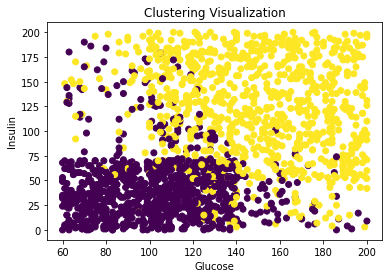

Accuracy : 91.01479915433404%


In [136]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Glucose"],
    data["Insulin"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Glucose")
plt.ylabel("Insulin")

plt.show()

counter = 0

for idx, row in data.iterrows():
  if row["Outcome"] == row["prediction"]:
    counter += 1

accuracy = counter / len(data) * 100
print(f"Accuracy : {accuracy}%")